# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

---
# Imports

In [207]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import wrds
import seaborn as sns
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from scipy.stats import mstats

from utils import plot_strategy_performance
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Load the data

In [221]:
# Complete data
data = pd.read_parquet("../data/stock_data.parquet")

# Part 3 data (BAB
data_bab = pd.read_parquet("../data/stock_data_part1.parquet")

In [222]:
data['date'] = pd.to_datetime(data['date'])  
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1425495 entries, 5 to 1437180
Data columns (total 15 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   permno  1425495 non-null  int64         
 1   date    1425495 non-null  datetime64[ns]
 2   Rn      1425495 non-null  float64       
 3   shrout  1425495 non-null  float64       
 4   prc     1425495 non-null  float64       
 5   siccd   1425495 non-null  int64         
 6   Rm      1425495 non-null  float64       
 7   rf      1425495 non-null  float64       
 8   mcap    1425495 non-null  float64       
 9   mcap_l  1425495 non-null  float64       
 10  Rn_f    1415474 non-null  float64       
 11  const   1425495 non-null  int64         
 12  Rn_e    1425495 non-null  float64       
 13  Rm_e    1425495 non-null  float64       
 14  w_m     1425495 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(3)
memory usage: 174.0 MB


---
# Idiosyncratic Volatility Strategy (IV)

(a) Compute the time-varying estimate for each stock’s idiosyncratic volatility $ σ^{idio}_{t,n} $ obtained as the volatility of the residual in the monthly rolling 5-year regressions of
stock-specific excess returns on the excess market return. Require at least 36 months
of observations for each stock. Winsorize the volatility at 5 and 95 %.

In [223]:
# Remove any potential NaN values
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# Remove rare stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

# Calculate the rolling covariance matrix
cov_nm = data.set_index('date').groupby('permno')[['Rn_e', 'Rm_e']].rolling(60, min_periods=36).cov()

# Extract the required components
cov_ee = cov_nm.iloc[0::2, 0].droplevel(2)
cov_em = cov_nm.iloc[0::2, 1].droplevel(2)
cov_mm = cov_nm.iloc[1::2, 1].droplevel(2)

# Calculate idio vol
beta = cov_em / cov_mm
idio_variance = cov_ee - beta**2 * cov_mm
idio_volatility = np.sqrt(idio_variance)

# Add the idiosyncratic volatility to the original dataframe
data = data.set_index(['permno', 'date'])
data['sigma_idio'] = idio_volatility

# Reset index to merge correctly
data = data.reset_index()

# Winsorize the idiosyncratic volatility at 5% and 95%
data['sigma_idio'] = data['sigma_idio'].clip(data['sigma_idio'].quantile(0.05),data['sigma_idio'].quantile(0.95))


In [224]:
data

,permno,date,Rn,shrout,prc,siccd,Rm,rf,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m,N,sigma_idio
35,10001,2012-12-31,-0.015231,8157.0,9.33,4925,0.012569,0.000021,76104.81,77654.64,0.062701,1,-0.015252,0.012548,0.000007,91,0.045513
36,10001,2013-01-31,0.062701,8157.0,9.87,4925,0.054142,0.000051,80509.59,76104.81,0.011651,1,0.062650,0.054091,0.000007,91,0.045345
37,10001,2013-02-28,0.011651,8157.0,9.94,4925,0.008282,0.000040,81080.58,80509.59,0.030684,1,0.011611,0.008242,0.000007,91,0.044767
38,10001,2013-03-28,0.030684,8157.0,10.20,4925,0.035295,0.000034,83201.40,81080.58,0.017157,1,0.030650,0.035261,0.000007,91,0.044767
39,10001,2013-04-30,0.017157,8390.0,10.33,4925,0.014939,0.000013,86668.70,83201.40,-0.000484,1,0.017144,0.014926,0.000007,91,0.044767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325988,93426,2023-07-31,0.006999,12577.0,37.41,3676,0.035624,0.004442,470505.57,467235.55,-0.037156,1,0.002557,0.031182,0.000021,161,0.062502
1325989,93426,2023-08-31,-0.037156,12581.0,36.02,3676,-0.020605,0.004463,453167.62,470505.57,-0.067740,1,-0.041619,-0.025068,0.000020,161,0.062086
1325990,93426,2023-09-29,-0.067740,12581.0,33.58,3676,-0.047390,0.004472,422469.98,453167.62,-0.108993,1,-0.072212,-0.051862,0.000020,161,0.059817
1325991,93426,2023-10-31,-0.108993,12581.0,29.92,3676,-0.028867,0.004475,376423.52,422469.98,0.019051,1,-0.113468,-0.033342,0.000019,161,0.060258


- Look up on the volatilities

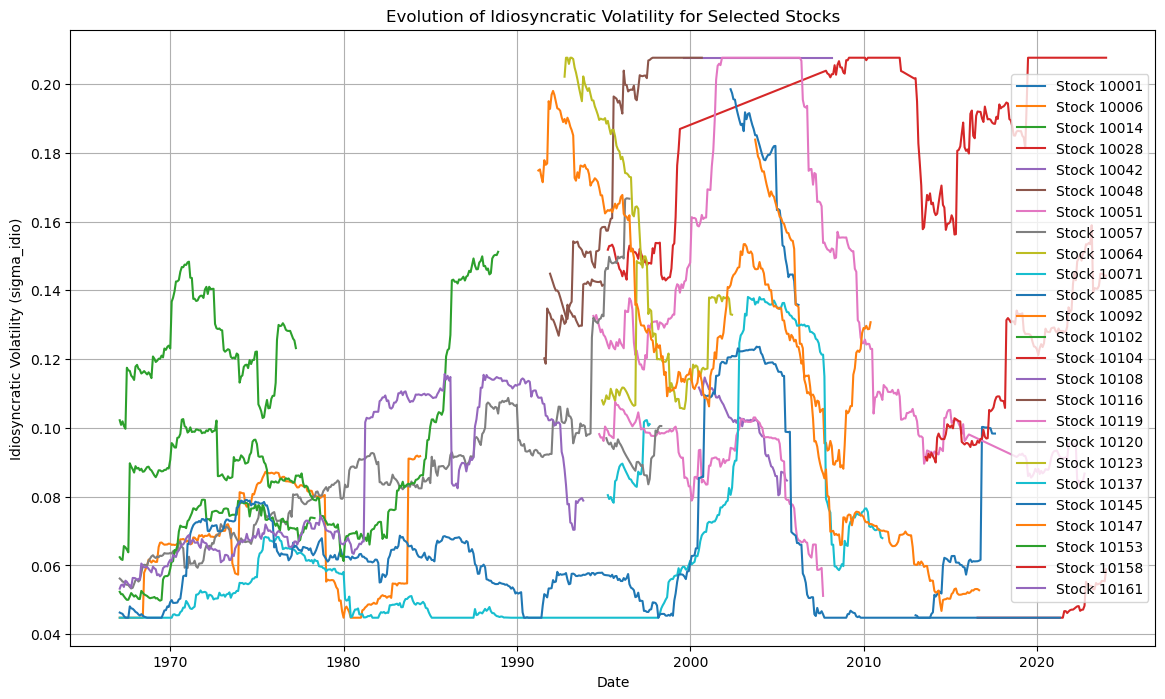

In [150]:
# Select five unique stocks for plotting
selected_stocks = data['permno'].unique()[:25]

# Filter data for the selected stocks
filtered_data = data[data['permno'].isin(selected_stocks)]

# Plot the idiosyncratic volatility over time for each selected stock
plt.figure(figsize=(14, 8))
for stock in selected_stocks:
    stock_data = filtered_data[filtered_data['permno'] == stock]
    plt.plot(stock_data['date'], stock_data['sigma_idio'], label=f'Stock {stock}')

plt.title('Evolution of Idiosyncratic Volatility for Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Idiosyncratic Volatility (sigma_idio)')
plt.legend()
plt.grid(True)
plt.show()

(b) At every month t, sort all stocks into deciles based on their idiosyncratic volatility
(estimated using the most recent rolling window). Then compute monthly returns for
10 decile portfolios that equal weight all stocks in each decile. Plot the average annu-
alized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in
three barplots. Repeat for value-weighted decile portfolios. Summarize your findings.
Is the evidence consistent with the CAPM?

In [128]:
# Sort stocks into deciles based on idiosyncratic volatility at each month
data = data.dropna(subset=['sigma_idio']).copy()
data['sigma_idio_decile'] = data.groupby('date')['sigma_idio'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Compute market weights within quintiles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'sigma_idio_decile'])['mcap'].transform('sum')

# Compute value-weighted returns for each decile
data['idio_ret_vw'] = data['vw_Q'] * data['Rn_e']
data['idio_ret_vw'] = data['idio_ret_vw'].clip(data['idio_ret_vw'].quantile(0.05),data['idio_ret_vw'].quantile(0.95))
ret_vw = data.groupby(['date', 'sigma_idio_decile'])['idio_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('sigma_idio_decile')['idio_ret_vw'].mean()

# Compute equal-weighted returns for each decile
ret_ew = data.groupby(['date', 'sigma_idio_decile'])['Rn_e'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('sigma_idio_decile')['Rn_e'].mean()

In [129]:
# Calculate annualized portfolio statistics
def calculate_stats(returns):
    mean_return = returns.mean() * 12
    std_dev = returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / std_dev
    return mean_return, std_dev, sharpe_ratio

# Compute value-weighted portfolio statistics
vw_stats = ret_vw.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['idio_ret_vw']))

# Compute equal-weighted portfolio statistics
ew_stats = ret_ew.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['Rn_e']))

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_82459/1795134258.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_stats = ret_vw.groupby('sigma_idio_decile').apply(lambda x: calculate_stats(x['idio_ret_vw']))
/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_82459/1795134258.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ew_stats = ret_ew.groupby('sigma_idio_decile').apply(la

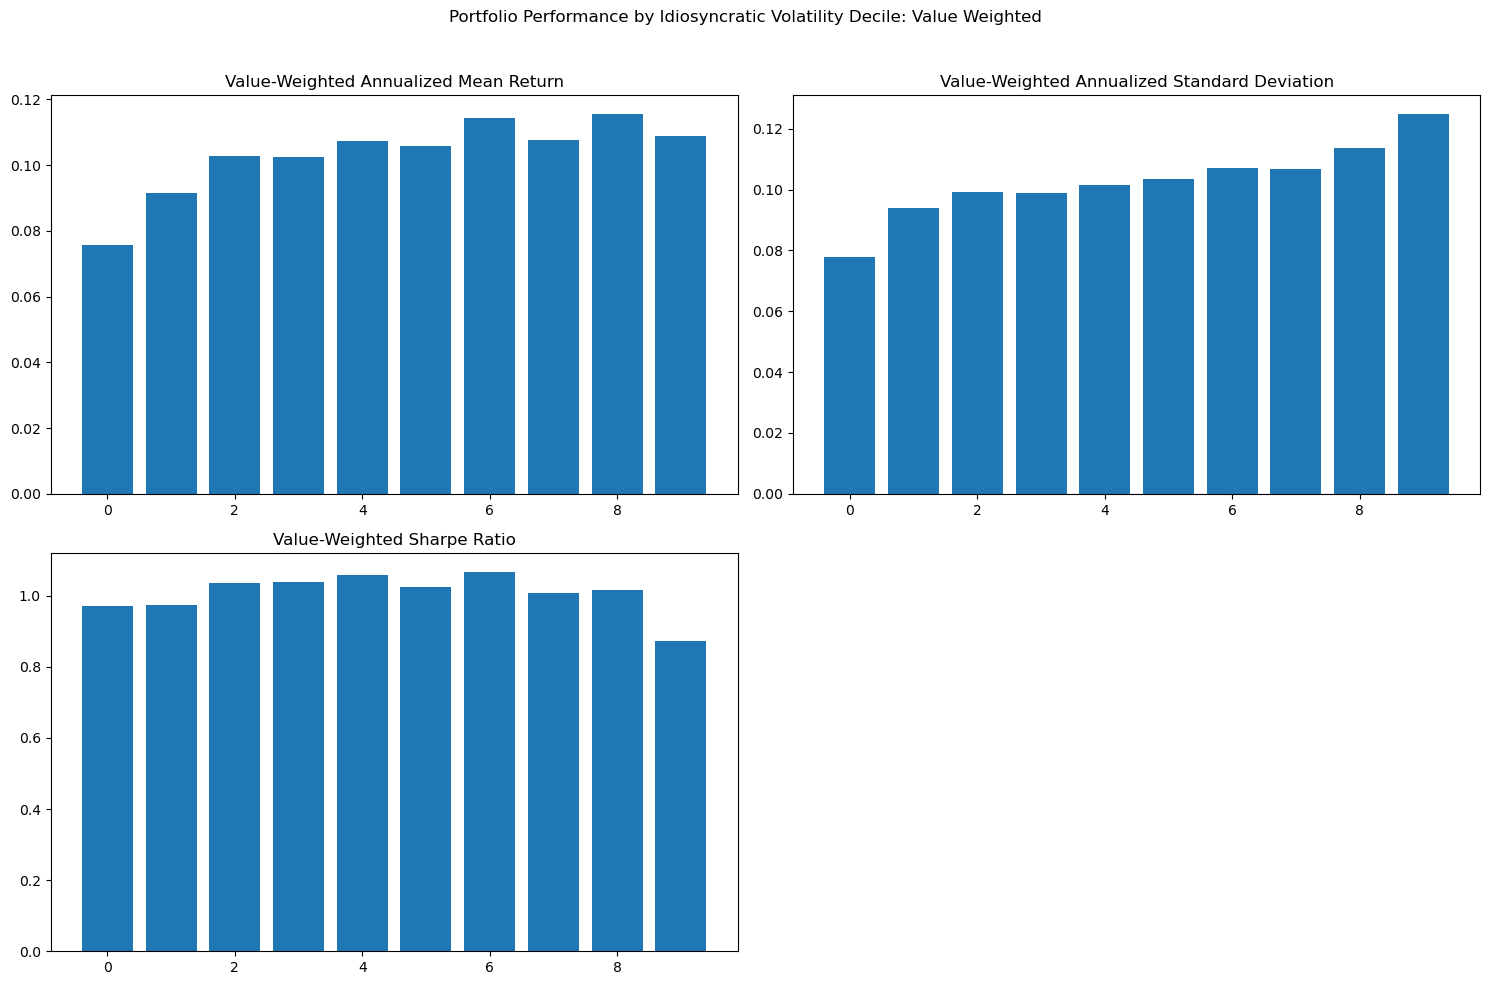

In [130]:
# Plot decile Val weighted
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Performance by Idiosyncratic Volatility Decile: Value Weighted')

# Value-Weighted Portfolios
axes[0, 0].bar(vw_stats.index, vw_stats.apply(lambda x: x[0]))
axes[0, 0].set_title('Value-Weighted Annualized Mean Return')

axes[0, 1].bar(vw_stats.index, vw_stats.apply(lambda x: x[1]))
axes[0, 1].set_title('Value-Weighted Annualized Standard Deviation')

axes[1, 0].bar(vw_stats.index, vw_stats.apply(lambda x: x[2]))
axes[1, 0].set_title('Value-Weighted Sharpe Ratio')


# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

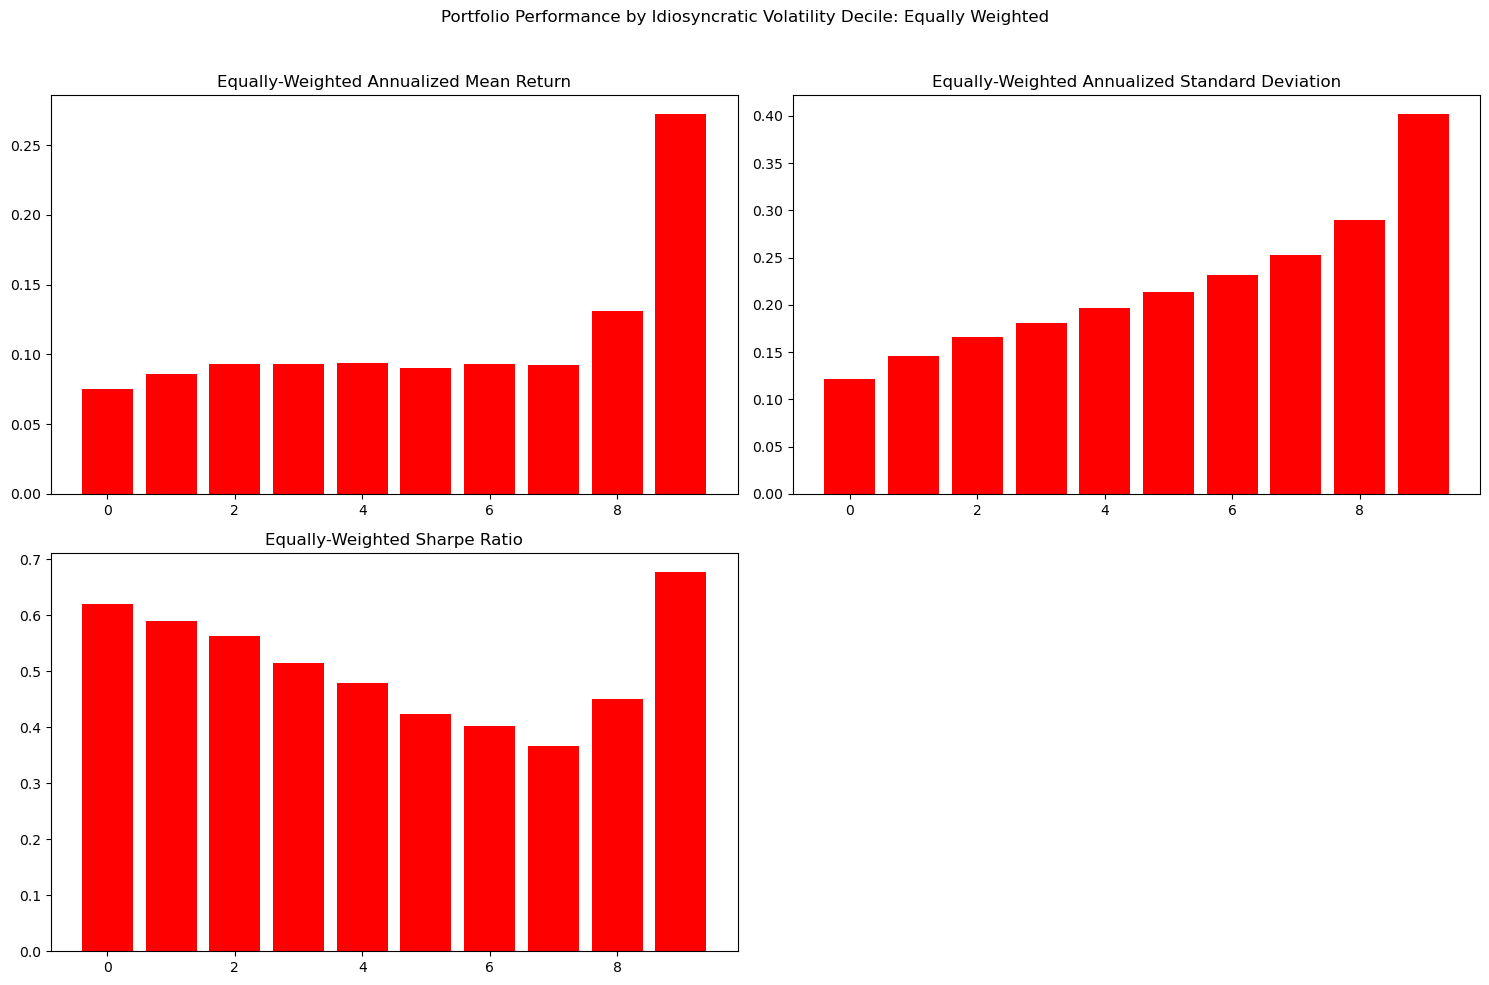

In [131]:
# Plot decile Equal weighted
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Performance by Idiosyncratic Volatility Decile: Equally Weighted')

# Equally-Weighted Portfolios
axes[0, 0].bar(ew_stats.index, ew_stats.apply(lambda x: x[0]), color='r')
axes[0, 0].set_title('Equally-Weighted Annualized Mean Return')

axes[0, 1].bar(ew_stats.index, ew_stats.apply(lambda x: x[1]), color='r')
axes[0, 1].set_title('Equally-Weighted Annualized Standard Deviation')

axes[1, 0].bar(ew_stats.index, ew_stats.apply(lambda x: x[2]), color='r')
axes[1, 0].set_title('Equally-Weighted Sharpe Ratio')

# Hide the fourth subplot
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

(c) Now we construct the idiosyncratic volatility factor. At every month t, we go long
the three highest decile volatility portfolios and we go short the three lowest decile
volatility portfolios. Compute and compare the mean, standard deviation, and Sharpe
ratios of the long and short legs of the strategy as well as of the strategy itself. Test if
the strategy has an average return that is statistically significantly different from zero.
Repeat both tests for equal and value-weighted portfolios. How do your results differ
from Ang, Hodrick, Xing, and Zhang (2006; table VI page 285) and what may be the
explanation for the difference?

In [132]:
#  Select stocks for long and short legs
long_leg_data = data[data['sigma_idio_decile'] >= 7]
short_leg_data = data[data['sigma_idio_decile'] < 3]

# Compute portfolio returns for long and short legs
long_leg_returns_vw = long_leg_data.groupby('date')['idio_ret_vw'].sum()
short_leg_returns_vw = short_leg_data.groupby('date')['idio_ret_vw'].sum()
long_leg_returns_ew = long_leg_data.groupby('date')['Rn_e'].mean()
short_leg_returns_ew = short_leg_data.groupby('date')['Rn_e'].mean()

# Calculate factor returns
factor_returns_vw = long_leg_returns_vw - short_leg_returns_vw
factor_returns_ew = long_leg_returns_ew - short_leg_returns_ew

# Factor returns
factor_mean_return_vw = factor_returns_vw.mean() * 12
factor_std_dev_vw = factor_returns_vw.std() * np.sqrt(12)
factor_sharpe_ratio_vw = factor_mean_return_vw / factor_std_dev_vw

factor_mean_return_ew = factor_returns_ew.mean() * 12
factor_std_dev_ew = factor_returns_ew.std() * np.sqrt(12)
factor_sharpe_ratio_ew = factor_mean_return_ew / factor_std_dev_ew

# Long and Short legs
long_mean_return_vw = long_leg_returns_vw.mean() * 12
long_std_dev_vw = long_leg_returns_vw.std() * np.sqrt(12)
long_sharpe_ratio_vw = long_mean_return_vw / long_std_dev_vw

short_mean_return_vw = short_leg_returns_vw.mean() * 12
short_std_dev_vw = short_leg_returns_vw.std() * np.sqrt(12)
short_sharpe_ratio_vw = short_mean_return_vw / short_std_dev_vw

long_mean_return_ew = long_leg_returns_ew.mean() * 12
long_std_dev_ew = long_leg_returns_ew.std() * np.sqrt(12)
long_sharpe_ratio_ew = long_mean_return_ew / long_std_dev_ew

short_mean_return_ew = short_leg_returns_ew.mean() * 12
short_std_dev_ew = short_leg_returns_ew.std() * np.sqrt(12)
short_sharpe_ratio_ew = short_mean_return_ew / short_std_dev_ew


# Significance test
t_stat_vw, p_value_vw = ttest_1samp(factor_returns_vw, 0)
t_stat_ew, p_value_ew = ttest_1samp(factor_returns_ew, 0)

In [133]:
# Print results
print("--------- Value-Weighted Portfolio Statistics: ---------")
print("\n--------- Long Leg")
print("Long Leg - Mean Return:", long_mean_return_vw)
print("Long Leg - Standard Deviation:", long_std_dev_vw)
print("Long Leg - Sharpe Ratio:", long_sharpe_ratio_vw)
print("\n--------- Short Leg")
print("Short Leg - Mean Return:", short_mean_return_vw)
print("Short Leg - Standard Deviation:", short_std_dev_vw)
print("Short Leg - Sharpe Ratio:", short_sharpe_ratio_vw)
print("\n--------- Factor Returns")
print("Factor Returns - Mean Return:", factor_mean_return_vw)
print("Factor Returns - Standard Deviation:", factor_std_dev_vw)
print("Factor Returns - Sharpe Ratio:", factor_sharpe_ratio_vw)
print("Factor Returns - T-statistic:", t_stat_vw)
print("Factor Returns - P-value:", p_value_vw)

print("\n--------- Equal-Weighted Portfolio Statistics: ---------")
print("\n--------- Long Leg")
print("Long Leg - Mean Return:", long_mean_return_ew)
print("Long Leg - Standard Deviation:", long_std_dev_ew)
print("Long Leg - Sharpe Ratio:", long_sharpe_ratio_ew)
print("\n--------- Short Leg")
print("Short Leg - Mean Return:", short_mean_return_ew)
print("Short Leg - Standard Deviation:", short_std_dev_ew)
print("Short Leg - Sharpe Ratio:", short_sharpe_ratio_ew)
print("\n--------- Factor Returns")
print("Factor Returns - Mean Return:", factor_mean_return_ew)
print("Factor Returns - Standard Deviation:", factor_std_dev_ew)
print("Factor Returns - Sharpe Ratio:", factor_sharpe_ratio_ew)
print("Factor Returns - T-statistic:", t_stat_ew)
print("Factor Returns - P-value:", p_value_ew)

--------- Value-Weighted Portfolio Statistics: ---------

--------- Long Leg
Long Leg - Mean Return: 0.3035890877978282
Long Leg - Standard Deviation: 0.3125203708930784
Long Leg - Sharpe Ratio: 0.9714217570210621

--------- Short Leg
Short Leg - Mean Return: 0.2697904702766923
Short Leg - Standard Deviation: 0.2640598103183259
Short Leg - Sharpe Ratio: 1.0217021285876786

--------- Factor Returns
Factor Returns - Mean Return: 0.033798617521135936
Factor Returns - Standard Deviation: 0.20303559253143866
Factor Returns - Sharpe Ratio: 0.16646646580403116
Factor Returns - T-statistic: 1.2558752105625193
Factor Returns - P-value: 0.20959128280456207

--------- Equal-Weighted Portfolio Statistics: ---------

--------- Long Leg
Long Leg - Mean Return: 0.15635436291227806
Long Leg - Standard Deviation: 0.2956147018508478
Long Leg - Sharpe Ratio: 0.5289126756326434

--------- Short Leg
Short Leg - Mean Return: 0.08476647850246943
Short Leg - Standard Deviation: 0.14085953028530682
Short Leg -

In [134]:
stats_data = pd.DataFrame({
    'Metric': ['Mean Return', 'Standard Deviation', 'Sharpe Ratio'],
    'Factor Returns (Value-Weighted)': [factor_mean_return_vw, factor_std_dev_vw, factor_sharpe_ratio_vw],
    'Factor Returns (Equal-Weighted)': [factor_mean_return_ew, factor_std_dev_ew, factor_sharpe_ratio_ew],
    'Long Leg (Value-Weighted)': [long_mean_return_vw, long_std_dev_vw, long_sharpe_ratio_vw],
    'Short Leg (Value-Weighted)': [short_mean_return_vw, short_std_dev_vw, short_sharpe_ratio_vw],
    'Long Leg (Equal-Weighted)': [long_mean_return_ew, long_std_dev_ew, long_sharpe_ratio_ew],
    'Short Leg (Equal-Weighted)': [short_mean_return_ew, short_std_dev_ew, short_sharpe_ratio_ew]
})
stats_data

,Metric,Factor Returns (Value-Weighted),Factor Returns (Equal-Weighted),Long Leg (Value-Weighted),Short Leg (Value-Weighted),Long Leg (Equal-Weighted),Short Leg (Equal-Weighted)
0,Mean Return,0.033799,0.071588,0.303589,0.269790,0.156354,0.084766
1,Standard Deviation,0.203036,0.209832,0.312520,0.264060,0.295615,0.140860
2,Sharpe Ratio,0.166466,0.341167,0.971422,1.021702,0.528913,0.601780


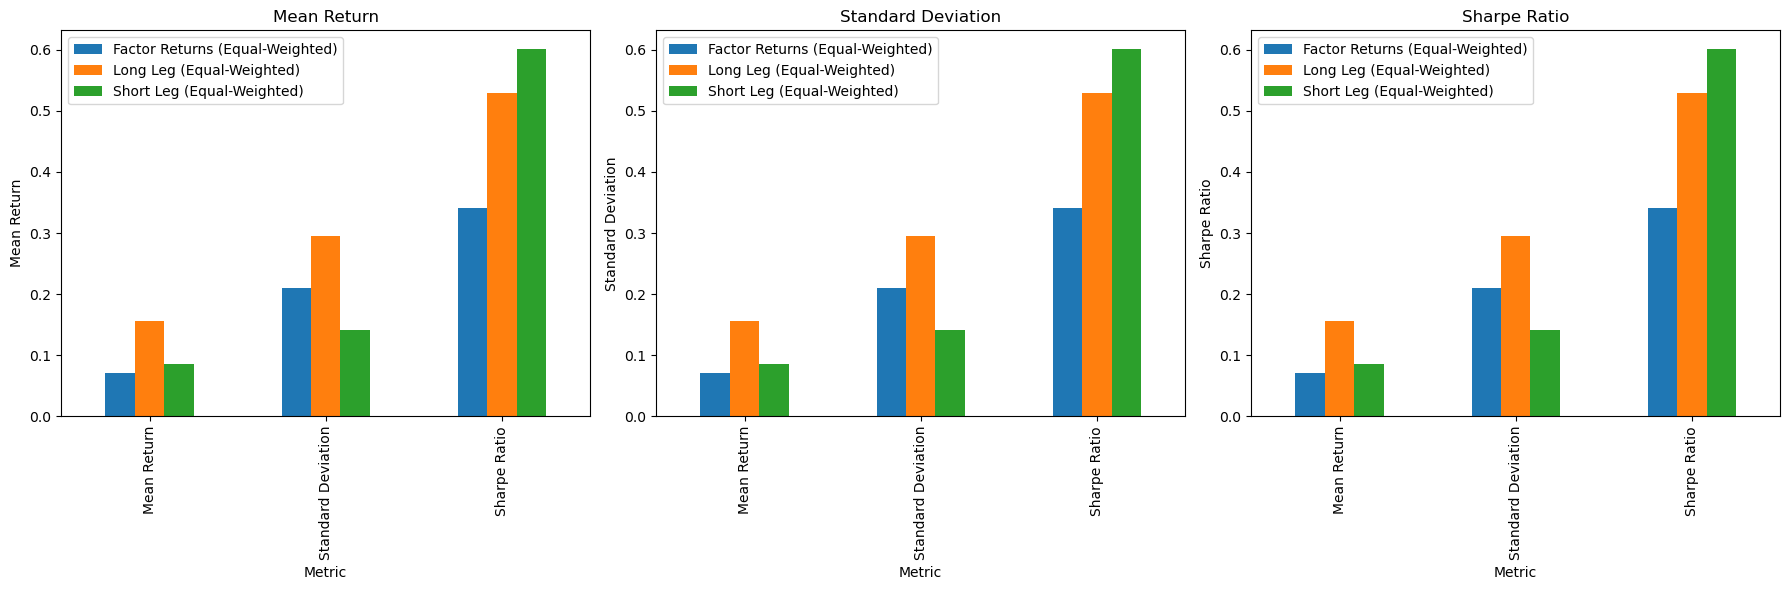

In [135]:
# Stats metrics
metrics = ['Mean Return', 'Standard Deviation', 'Sharpe Ratio']

# Equal-Weighted
plot_strategy_performance(metrics=metrics, data=stats_data, columns=[f'Factor Returns (Equal-Weighted)', f'Long Leg (Equal-Weighted)', f'Short Leg (Equal-Weighted)'])

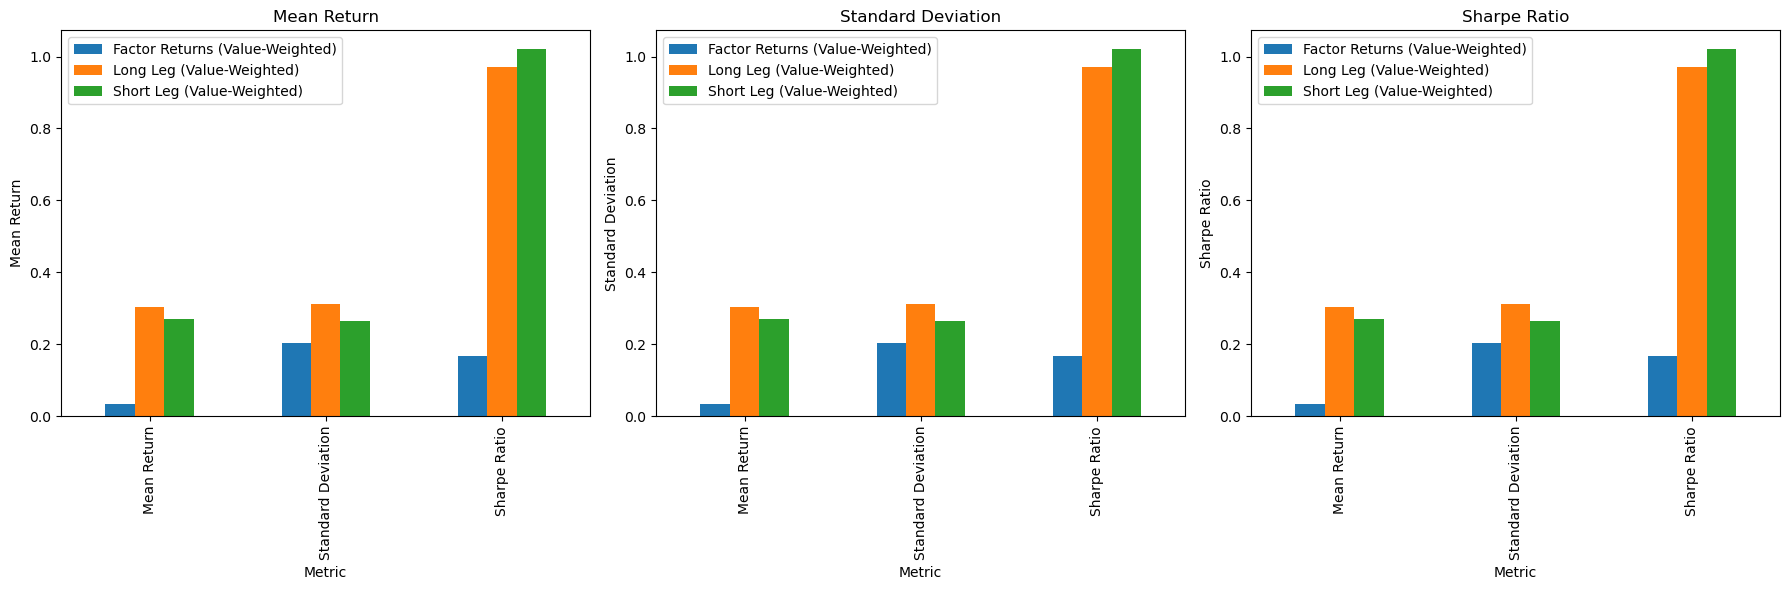

In [136]:
# Value-Weighted
plot_strategy_performance(metrics=metrics, data=stats_data, columns=[f'Factor Returns (Value-Weighted)', f'Long Leg (Value-Weighted)', f'Short Leg (Value-Weighted)'])